## Variant 1

In [27]:
#import qiskit as qs
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.operators.state_fns import CircuitStateFn
from qiskit.aqua.algorithms import NumPyEigensolver
#from qiskit import BasicAer, execute
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.operators import PauliExpectation, CircuitSampler, StateFn
import itertools
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [28]:
def prepare_Hb(a,b):
    
    pauli_dict = {
        'paulis': [
                   {"coeff": {"imag": 0.0, "real": a}, "label": "XI"},
                   {"coeff": {"imag": 0.0, "real": b}, "label": "IX"}
                  ]}
    return WeightedPauliOperator.from_dict(pauli_dict)

In [29]:
def prepare_Ha(a, b):
        
    pauli_dict = {
        'paulis': [
                   {"coeff": {"imag": 0.0, "real": a}, "label": "ZI"},
                   {"coeff": {"imag": 0.0, "real": b}, "label": "ZZ"},
                  ]
    }
    return WeightedPauliOperator.from_dict(pauli_dict)

In [30]:
def add_U_Ha(circuit,gamma):
    q = circuit.qregs[0]
    #RZ on first qubit
    circuit.u1(gamma,q[0])
    #circuit.rz(gamma,q[0])
    
    
    #Realize second term in power of matrix exponential
    circuit.cnot(q[0],q[1])
    circuit.u1(gamma, q[1])
    #circuit.rz(gamma,q[1])
    circuit.cnot(q[0],q[1])
    
    return circuit
  

In [31]:
def add_U_Hb(circuit,beta):
    q = circuit.qregs[0]
    
    #RX on first qubit
    circuit.rx(2*beta,q[0])
    #circuit.h(q[0])
    #circuit.u1(beta,q[0])
    #circuit.h(q[0])
    
    
    #RX on second qubit
    circuit.rx(2*beta,q[1])
    #circuit.h(q[1])
    #circuit.u1(beta,q[1])
    #circuit.h(q[1])
    
    return circuit

In [32]:
def add_ansatz_layer(circuit, gamma, beta):
    q = circuit.qregs[0]
    circuit = add_U_Ha(circuit, gamma)
    #circuit.barrier()
    circuit = add_U_Hb(circuit, beta)
    #circuit.barrier()
    return circuit



In [33]:
def ansatz(arr_gamma, arr_beta):
    
    #print(arr_gamma)
    p = len(arr_gamma)
    #if p not in [2]:
    #     print(arr_gamma)
    
    q = QuantumRegister(2)
    #c = ClassicalRegister(2)
    circuit = QuantumCircuit(q)
    
    # quantum state preparation
    circuit.h(q[0])
    circuit.h(q[1])
    #circuit.barrier()
    
    
    for ind in range(p):
        circuit = add_ansatz_layer(circuit, arr_gamma[ind], arr_beta[ind])
    return circuit

In [34]:
def expectation(ansatz,Hamiltonian):
    H_operator = Hamiltonian.to_opflow()
    psi = CircuitStateFn(ansatz)
    '''
    # easy expectation value, use for small systems only!
    result = psi.adjoint().compose(H_operator).compose(psi).eval().real
    
    '''
    backend = Aer.get_backend('qasm_simulator') 
    q_instance = QuantumInstance(backend, shots=1024)

    measurable_expression = StateFn(H_operator, is_measurement=True).compose(psi) 
    expectation = PauliExpectation().convert(measurable_expression)  
    sampler = CircuitSampler(q_instance).convert(expectation) 

    # evaluate
    result = sampler.eval().real
    
    return result

In [35]:
def evaluation(arr_gamma_p, arr_beta_p):
    Ha = prepare_Ha(0.5, 0.5)
    res = np.zeros(len(arr_gamma_p))
    inc=0
    for [i,j] in zip(arr_gamma_p,arr_beta_p):
        test = ansatz(i,j)
        res[inc] = expectation(test, Ha)
        inc = inc+1
    return res

In [36]:
def evaluation2(variables,p=1):
    if p not in [1,2]:
        print("Invalid p")
        return
    if len(variables) != 2:
        variables = [[variables[0],variables[1]],[variables[2],variables[3]]]
   
    gamma = variables[0]
    beta  = variables[1]
    #print(variables,'-----')
    if p != 2:
        gamma = [gamma]
        beta = [beta]
    Ha = prepare_Ha(0.5, 0.5)
    test = ansatz(gamma,beta)
    
    res = expectation(test, Ha)
    return res

In [37]:
evaluation2([1,10],1)# [g1,b1]

0.2529296874999999

In [38]:
evaluation2([1,0,1,0],2)# [g1,g1,b1,b2]

-0.26171875

## Question 2.1
#### Using the Hamiltonian $ H_{EC}$    given in the previous question, compute the variational state $ \mid\:\gamma,\:\beta\:> $  for p=1 

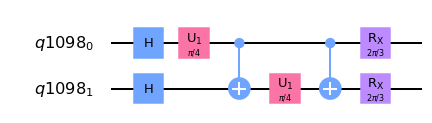

In [39]:
#Draw ansatz
example = ansatz([np.pi/4],[np.pi/3])
example.draw(output='mpl')

## Question 2.2

#### Compute the expectation value of the energy $ <\gamma,\:\beta\:|\:H\:|\:\gamma,\:\beta\:> $  and plot it as a function of the variational parameters $ \gamma  $ and $ \beta   $ ;

(126,) (126,)


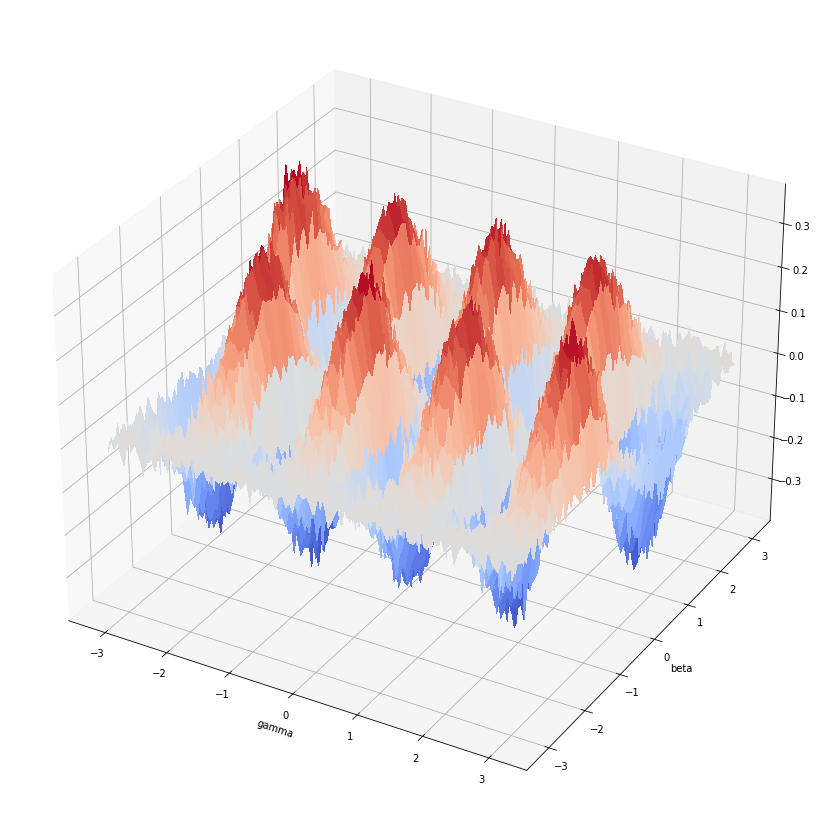

In [81]:
## Check for p=1

gamma = np.arange(-np.pi, np.pi, 0.05)
beta = np.arange(-np.pi, np.pi, 0.05)
func = np.zeros( (gamma.size, beta.size) )
print(gamma.shape, beta.shape)
counter_y = 0

for j in beta:
    counter_x = 0
    for i in gamma:
        func[counter_x, counter_y] = evaluation2([i,j],1)
        counter_x += 1
    counter_y += 1

X, Y = np.meshgrid(beta, gamma)

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
#ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X, Y, func, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.xlabel('gamma')
plt.ylabel('beta')
plt.show()

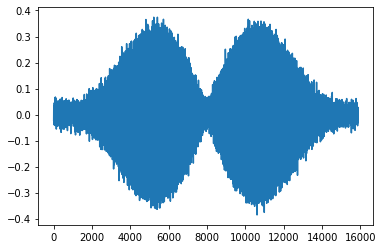

In [82]:
plt.plot(func.flatten())

## Question 2.3
#### Minimize the energy. What are the optimal angles $ \gamma^* $ , $ \beta^* $? 

In [40]:
import scipy.optimize as optimize

bound_g1 = (0,np.pi)
bound_b1 = (0,np.pi)
initial_guess = (0, np.pi/2)
result = optimize.minimize(evaluation2,  x0=initial_guess , bounds=[bound_g1,bound_b1])

In [41]:
result

      fun: -0.014648437500000083
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1074218.75      ,  1855468.76127655])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 63
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([0.        , 1.57079633])

In [42]:
opt_angles = result.x
print(opt_angles)

[0.         1.57079633]


## Question 2.4
#### Compute the variational state obtained for the optimal angles $ |\:\gamma\ast,\:\beta\ast> $

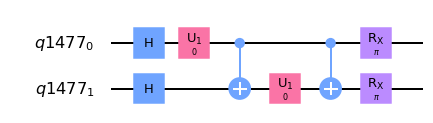

In [43]:
circuit_opt = ansatz([opt_angles[0]],[opt_angles[1]])
circuit_opt.draw(output='mpl')

## Question 2.5
#### Compute the success probability $ |<1,0|\:\gamma\ast,\:\beta\ast>|^2 $;

In [44]:
# one-zero state
q10 = QuantumRegister(2)
one_zero_circuit = QuantumCircuit(q10)
one_zero_circuit.x(q10[0])

In [45]:
one_zero_state = CircuitStateFn(one_zero_circuit)
psi = CircuitStateFn(circuit_opt)
result = (abs(one_zero_state.adjoint().compose(psi).eval()))**2
print('Probability =',result)

Probability = 0.25


## Question 2.6
#### Show numerically that with p=2 a success probability of 100% is obtained (2 pts).

In [46]:
#Gradient based optimization

initial_guess = (np.pi, 0, 0, 0)
bound_g1 = (0,np.pi)
bound_g2 = (0,np.pi)
bound_b1 = (0,np.pi)
bound_b2 = (0,np.pi)
result = optimize.minimize(evaluation2,  x0=initial_guess, args=(2), bounds=[bound_g1,bound_g2,bound_b1,bound_b2])
opt_angles_p2 = result.x

'''
# Annealing
import scipy.optimize as spo
initial_guess = (np.pi, 0, 0, 0)
anneal_solution = spo.dual_annealing(evaluation2, x0=initial_guess, maxiter = 100, args=(2,), bounds=[bound_g1,bound_g2,bound_b1,bound_b2])
#print(anneal_solution)
opt_angles_p2 = anneal_solution.x
print(opt_angles_p2)
'''

'\n# Annealing\nimport scipy.optimize as spo\ninitial_guess = (np.pi, 0, 0, 0)\nanneal_solution = spo.dual_annealing(evaluation2, x0=initial_guess, maxiter = 100, args=(2,), bounds=[bound_g1,bound_g2,bound_b1,bound_b2])\n#print(anneal_solution)\nopt_angles_p2 = anneal_solution.x\nprint(opt_angles_p2)\n'

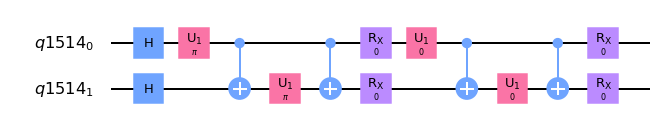

In [47]:
opt_g1 = opt_angles_p2[0]
opt_g2 = opt_angles_p2[1]
opt_b1 = opt_angles_p2[2]
opt_b2 = opt_angles_p2[3]
circuit_opt_p2 = ansatz([opt_g1 ,opt_g2],[opt_b1 ,opt_b2])
circuit_opt_p2.draw(output='mpl')

In [49]:
chi = CircuitStateFn(circuit_opt_p2)
result = (abs(one_zero_state.adjoint().compose(chi).eval()))**2
print('Probability =',result)

Probability = 0.25


## Classical

In [121]:
H = prepare_Ha(0.5, 0.5)
spectral_result = NumPyEigensolver(H).run()
min_eigenval = min(np.real(spectral_result.eigenvalues))
print('The minimal eigenvalue is: {}'.format(min_eigenval))


The minimal eigenvalue is: -1.0


In [122]:
spectral_result.eigenstates

ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
            dims=(2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)